# Segmentation
* 학습 내용
    1. dataset
        - kitti 데이터셋 준비
    2. model
        - U-Net
    3. visualization  
  
* Task
    - 주행 데이터에서 도로 영역을 분리하는 것이 목표  
    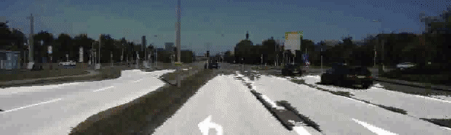

* Kitti 데이터셋 예시
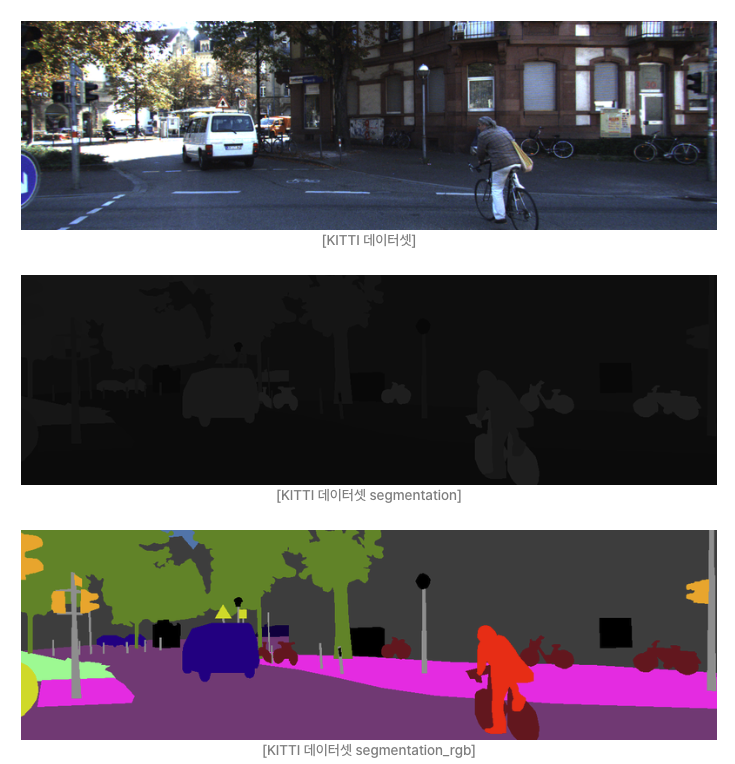

In [1]:
# import library

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
import tensorflow.keras.activations as act
import keras.backend as K

## 1. 이미지 데이터 준비

### 1) 데이터 증강

* albumutation augmentation

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                    ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                    )
                ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                )
            ])

* 데이터 시각화

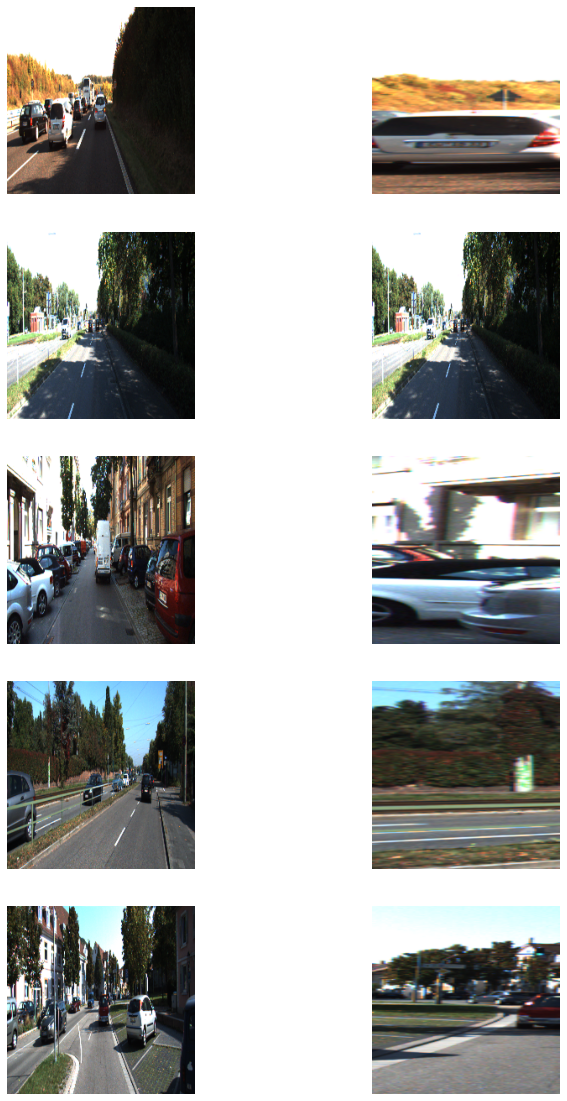

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.axis("off")
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.axis("off")
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### 2) 데이터셋 구성
* tf.keras.utils.Sequence를 상속받은 generator 형태로 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속
  KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path
    batch_size: batch_size
    img_size: preprocess에 사용할 입력이미지의 크기
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: 이 Generator가 학습용인지 테스트용인지 구분
    augmentation: 적용하길 원하는 augmentation 함수
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드
    # 이때 is_train에 따라 test set을 분리해서 load
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력은 resize및 augmentation이 적용된 input image
    # 출력은 semantic label
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

### 3) train, test Data Generator 생성

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
for t in train_generator:
    print(t[0].shape)
    print(t[1].shape)
    break

(16, 224, 224, 3)
(16, 224, 224)


## 2. Semantic Segmentation Model
* U-Net Model based
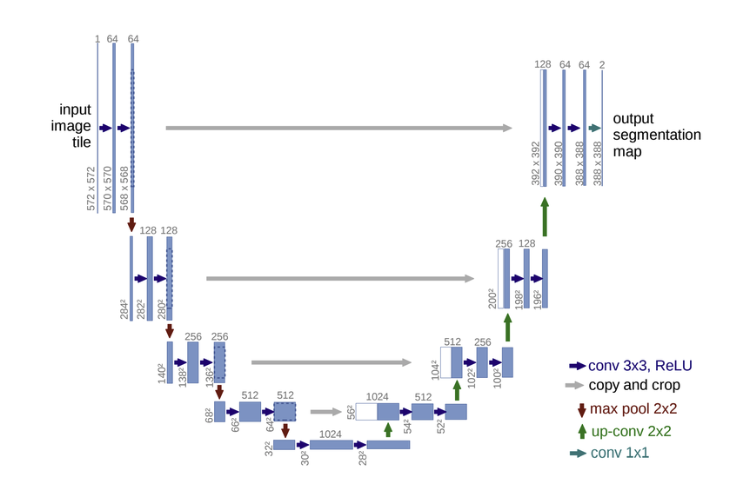

### 1) 모델 구조 만들기
* Kitti 데이터 크기에 적절하게 U-Net 구조를 변형하였음

In [65]:
def build_model(input_shape=(224, 224, 3)):
    
    # input
    inputs = Input(shape=input_shape)
    
    # Contracting path
    x = Conv2D(filters=64, kernel_size=3, activation=act.relu, name="contract_conv1-1")(inputs)
    conv1 = Conv2D(filters=64, kernel_size=3, activation=act.relu, name="contract_conv1-2")(x)
    
    x = MaxPooling2D(pool_size=2)(conv1)
    x = Conv2D(filters=128, kernel_size=3, activation=act.relu, name="contract_conv2-1")(x)
    conv2 = Conv2D(filters=128, kernel_size=3, activation=act.relu, name="contract_conv2-2")(x)
    
    x = MaxPooling2D(pool_size=2)(conv2)
    x = Conv2D(filters=256, kernel_size=3, activation=act.relu, name="contract_conv3-1")(x)
    conv3 = Conv2D(filters=256, kernel_size=3, activation=act.relu, name="contract_conv3-2")(x)
    
#     x = MaxPooling2D(pool_size=2)(conv3)
#     x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="contract_conv4-1")(x)
#     conv4 = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="contract_conv4-1")(x)

    x = MaxPooling2D(pool_size=2)(conv3)
    x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="classification_conv1-1")(x)
    x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="classification_conv1-2")(x)
    x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="classification_conv1-3")(x)
    x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="classification_conv1-4")(x)
    x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="classification_conv1-5")(x)

    # Expanding path
#     x = Conv2DTranspose(filters=512, kernel_size=2, strides=2, activation=act.relu, name="transpose_conv4")(x)
#     crop_conv4 = CenterCrop(*x.shape[1:3])(conv4)
#     concat_conv4 = Concatenate()([x, crop_conv4])
#     x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="expand_conv4-1")(concat_conv4)
#     x = Conv2D(filters=512, kernel_size=3, activation=act.relu, name="expand_conv4-2")(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=2, strides=2, activation=act.relu, name="transpose_conv3")(x)
    crop_conv3 = CenterCrop(*x.shape[1:3])(conv3)
    concat_conv3 = Concatenate()([x, crop_conv3])
    x = Conv2D(filters=256, kernel_size=3, activation=act.relu, name="expand_conv3-1")(concat_conv3)
    x = Conv2D(filters=256, kernel_size=3, activation=act.relu, name="expand_conv3-2")(x)

    x = Conv2DTranspose(filters=128, kernel_size=2, strides=2, activation=act.relu, name="transpose_conv2")(x)
    crop_conv2 = CenterCrop(*x.shape[1:3])(conv2)
    concat_conv2 = Concatenate()([x, crop_conv2])
    x = Conv2D(filters=128, kernel_size=3, activation=act.relu, name="expand_conv2-1")(concat_conv2)
    x = Conv2D(filters=128, kernel_size=3, activation=act.relu, name="expand_conv2-2")(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=2, strides=2, activation=act.relu, name="transpose_conv1")(x)
    crop_conv1 = CenterCrop(*x.shape[1:3])(conv1)
    concat_conv1 = Concatenate()([x, crop_conv1])
    x = Conv2D(filters=64, kernel_size=3, activation=act.relu, name="expand_conv1-1")(concat_conv1)
    x = Conv2D(filters=64, kernel_size=3, activation=act.relu, name="expand_conv1-2")(x)
    
    # output
    outputs = Conv2D(filters=1, kernel_size=1, activation=act.sigmoid, name="output")(x)
#     outputs = Resizing(*input_shape[:2])(outputs)
#     outputs = Reshape(input_shape[:2])(outputs)
    return Model(inputs=inputs, outputs=outputs)

In [5]:
x = np.random.randn(16, 224, 224, 3)
print("input", x.shape)
model = build_model()
outputs = model(x)
print("output", outputs.shape)

input (16, 224, 224, 3)
output (16, 224, 224)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
contract_conv1-1 (Conv2D)       (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
contract_conv1-2 (Conv2D)       (None, 220, 220, 64) 36928       contract_conv1-1[0][0]           
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 110, 110, 64) 0           contract_conv1-2[0][0]           
______________________________________________________________________________________________

* class 1 accuracy metric

In [7]:
def class_1_accuracy(y_true, y_pred):
    class_1_index = y_true == 1
    pred = K.round(y_pred)
    class_1_true = y_true[class_1_index]
    class_1_pred = pred[class_1_index]
    return accuracy_score(class_1_true, class_1_pred)

* IoU score 계산

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IoU : %f' % iou_score )
    return iou_score

* 추론 결과 시각화

In [12]:
def get_output(model, preproc, image_path, label_path, threshold=0.5):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=threshold).astype(np.uint8)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### 2) 모델 학습

In [67]:
model_path = "./model/seg_model_unet_e100.keras"

model = build_model()
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=["accuracy"])

csv_logger = tf.keras.callbacks.CSVLogger("./history/model_e100.log")

model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[csv_logger]
 )

model.save(model_path)

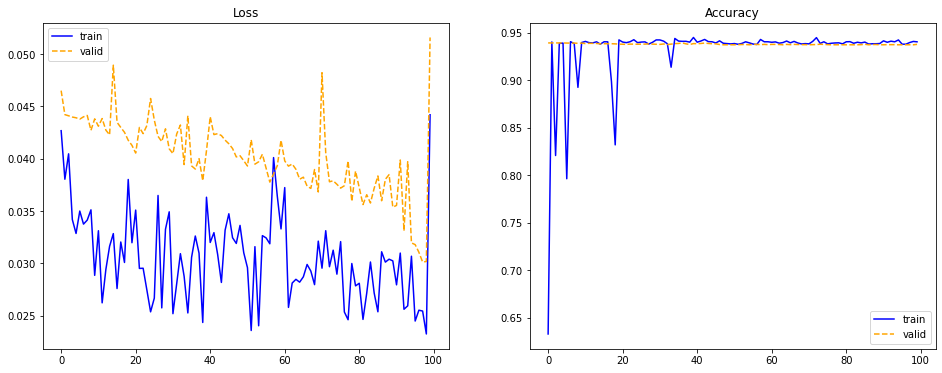

In [18]:
history_e100 = pd.read_csv("./history/model_e100.log")

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Loss")
plt.plot(history_e100["epoch"], history_e100["loss"], color="blue", label="train")
plt.plot(history_e100["epoch"], history_e100["val_loss"], color="orange", linestyle='dashed', label="valid")
plt.legend()

plt.subplot(122)
plt.title("Accuracy")
plt.plot(history_e100["epoch"], history_e100["accuracy"], color="blue", label="train")
plt.plot(history_e100["epoch"], history_e100["val_accuracy"], color="orange", linestyle='dashed', label="valid")
plt.legend()

plt.show()

accuracy score가 이상하다. 추론 결과를 시각화해보자.

In [14]:
# 테스트 이미지

i = 1

image_path = dir_path+f'/image_2/00{str(i).zfill(4)}_10.png'
test_image = imread(image_path)
test_image = test_preproc(**{"image":test_image})["image"]

label_path = dir_path+f'/semantic/00{str(i).zfill(4)}_10.png'
test_label = imread(label_path)
test_label = test_preproc(**{"image":test_label})["image"]

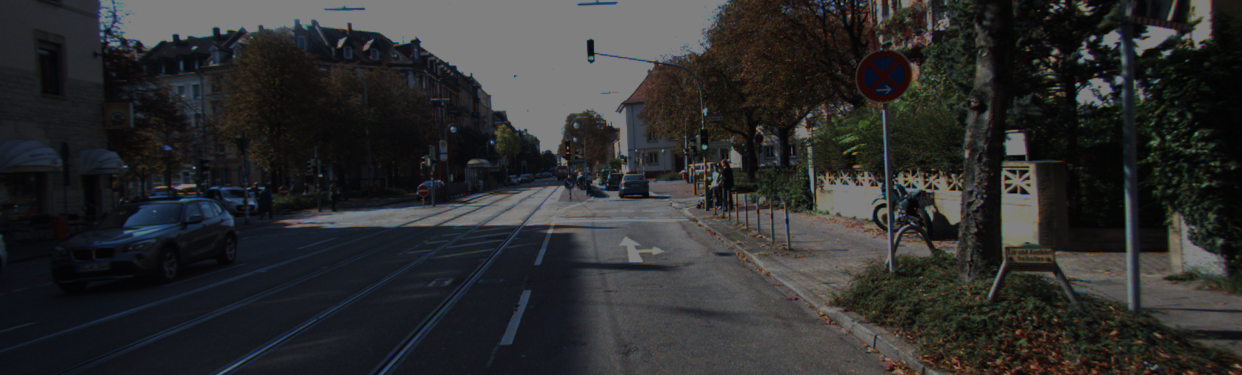

IoU : 0.000000


0.0

In [23]:
output, prediction, target = get_output(
    model, 
    test_preproc,
    image_path=image_path,
    label_path=label_path,
    threshold=0.5
 )

calculate_iou_score(target, prediction)

* threshold을 넘는 영역이 없는 것 같다.
* threshold을 조절하면서 시각화해보자.

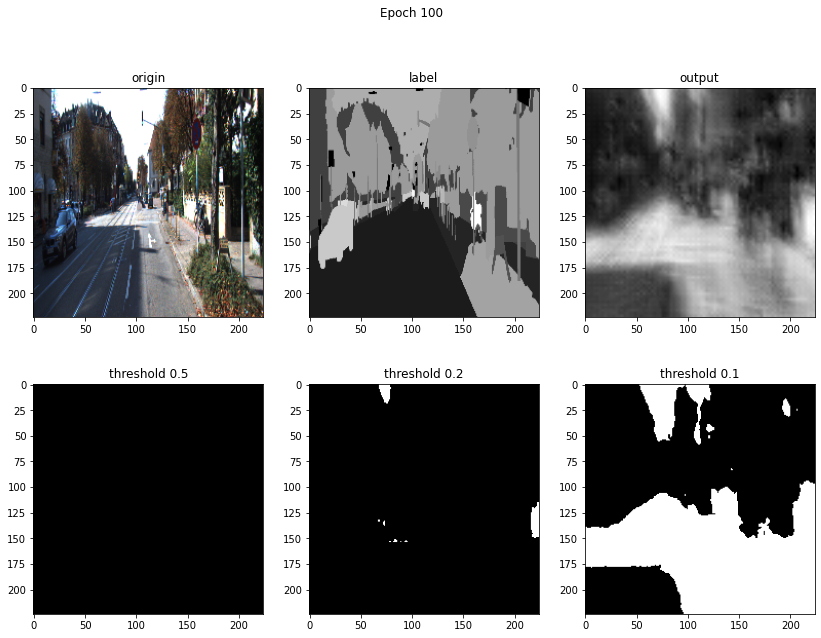

In [34]:
model_path = "./model/seg_model_unet_e100.h5"
model = build_model()
model.load_weights(model_path)

output = model.predict(np.expand_dims(test_image/255,axis=0))[0]

plt.figure(figsize=(14, 10))
plt.suptitle(f"Epoch 100")
plt.subplot(231)
plt.title("origin")
plt.imshow(test_image)
plt.subplot(232)
plt.title("label")
plt.imshow(test_label, cmap="gray")
plt.subplot(233)
plt.title("output")
plt.imshow(output, cmap="gray")
plt.subplot(234)
plt.title("threshold 0.5")
plt.imshow(tf.where(output >= 0.5, 1, 0), cmap="gray")
plt.subplot(235)
plt.title("threshold 0.2")
plt.imshow(tf.where(output >= 0.2, 1, 0), cmap="gray")
plt.subplot(236)
plt.title("threshold 0.1")
plt.imshow(tf.where(output >= 0.1, 1, 0), cmap="gray")
plt.show()

학습이 충분히 이루어지지 않은 결과인것 같다. 예측 값 히스토그램을 확인해보자.

In [37]:
print("Loss", BinaryCrossentropy()(test_label, output).numpy())

Loss 37.947254


<AxesSubplot:ylabel='Count'>

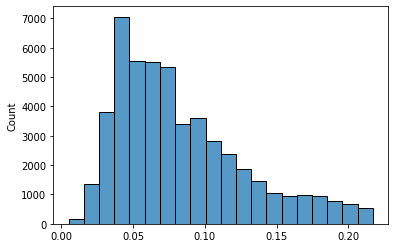

In [24]:
sns.histplot(data=output.reshape(-1), bins=20)

* 손실이 그래프 보다 높고, 분포가 거의 0에 가까운 것을 볼 수 있다.  
* 300 epoch 으로 학습해보자.

In [ ]:
model_path = "./model/seg_model_unet_e300.keras"

model = build_model()
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=[class_1_accuracy])

csv_logger = tf.keras.callbacks.CSVLogger("./history/model_e300.log")

model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=300,
    callbacks=[csv_logger]
 )

model.save(model_path)

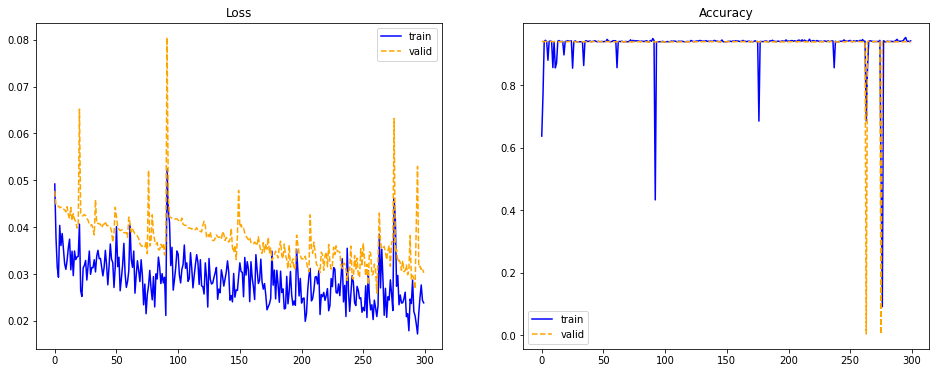

In [25]:
history_e300 = pd.read_csv("./history/model_e300.log")

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Loss")
plt.plot(history_e300["epoch"], history_e300["loss"], color="blue", label="train")
plt.plot(history_e300["epoch"], history_e300["val_loss"], color="orange", linestyle='dashed', label="valid")
plt.legend()

plt.subplot(122)
plt.title("Accuracy")
plt.plot(history_e300["epoch"], history_e300["accuracy"], color="blue", label="train")
plt.plot(history_e300["epoch"], history_e300["val_accuracy"], color="orange", linestyle='dashed', label="valid")
plt.legend()

plt.show()

* epoch 100 보다는 더 수렴한 것을 볼 수 있다.  
* 그래프 상으로 판단해봤을 때 아직 다 수렴하지 않았기 때문에 더 학습 여지가 남아있다.

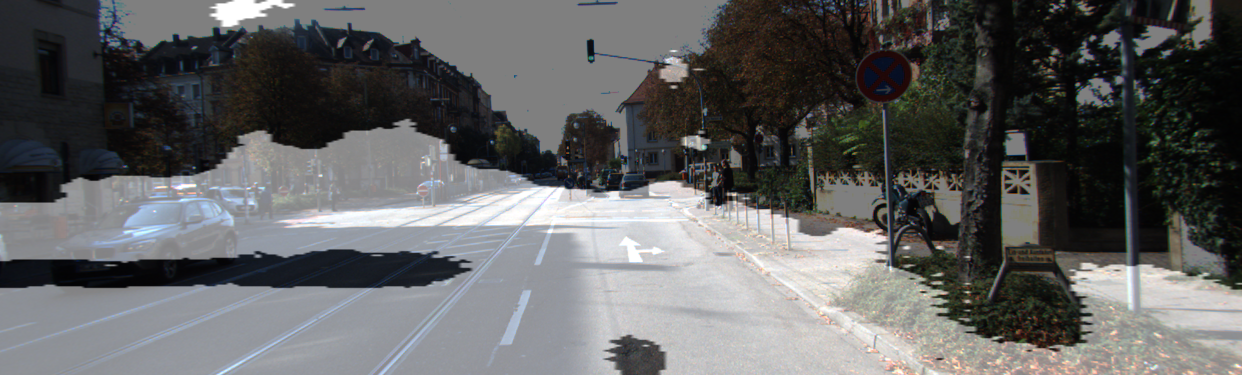

IoU : 0.527546


0.5275462962962963

In [40]:
output, prediction, target = get_output(
    model, 
    test_preproc,
    image_path=image_path,
    label_path=label_path,
    threshold=0.4
 )

calculate_iou_score(target, prediction)

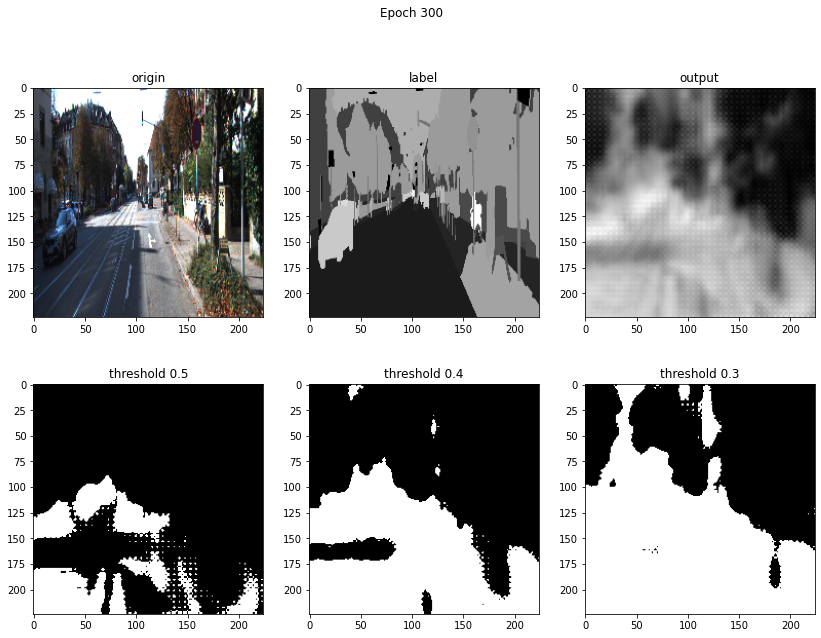

In [38]:
model_path = "./model/seg_model_unet_e300.keras"
model = build_model()
model.load_weights(model_path)

output = model.predict(np.expand_dims(test_image/255,axis=0))[0]

plt.figure(figsize=(14, 10))
plt.suptitle(f"Epoch 300")
plt.subplot(231)
plt.title("origin")
plt.imshow(test_image)
plt.subplot(232)
plt.title("label")
plt.imshow(test_label, cmap="gray")
plt.subplot(233)
plt.title("output")
plt.imshow(output, cmap="gray")
plt.subplot(234)
plt.title("threshold 0.5")
plt.imshow(tf.where(output >= 0.5, 1, 0), cmap="gray")
plt.subplot(235)
plt.title("threshold 0.4")
plt.imshow(tf.where(output >= 0.4, 1, 0), cmap="gray")
plt.subplot(236)
plt.title("threshold 0.3")
plt.imshow(tf.where(output >= 0.3, 1, 0), cmap="gray")
plt.show()

* 1000 epoch 까지 학습하면서 100 epoch 단위로 save해서 비교해보자

In [15]:
model_path = "./model/seg_model_unet_e1000.keras"

model = build_model()
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=[class_1_accuracy])

csv_logger = tf.keras.callbacks.CSVLogger("./history/model_e1000.log")
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    save_freq=11*100
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
)

model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=1000,
    callbacks=[csv_logger, ckpt, early_stop]
 )

model.save(model_path)

Epoch 1/1000


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:622 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/utils.py:72 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['contract_conv1-1/kernel:0', 'contract_conv1-1/bias:0', 'contract_conv1-2/kernel:0', 'contract_conv1-2/bias:0', 'contract_conv2-1/kernel:0', 'contract_conv2-1/bias:0', 'contract_conv2-2/kernel:0', 'contract_conv2-2/bias:0', 'contract_conv3-1/kernel:0', 'contract_conv3-1/bias:0', 'contract_conv3-2/kernel:0', 'contract_conv3-2/bias:0', 'classification_conv1-1/kernel:0', 'classification_conv1-1/bias:0', 'classification_conv1-2/kernel:0', 'classification_conv1-2/bias:0', 'classification_conv1-3/kernel:0', 'classification_conv1-3/bias:0', 'classification_conv1-4/kernel:0', 'classification_conv1-4/bias:0', 'classification_conv1-5/kernel:0', 'classification_conv1-5/bias:0', 'transpose_conv3/kernel:0', 'transpose_conv3/bias:0', 'expand_conv3-1/kernel:0', 'expand_conv3-1/bias:0', 'expand_conv3-2/kernel:0', 'expand_conv3-2/bias:0', 'transpose_conv2/kernel:0', 'transpose_conv2/bias:0', 'expand_conv2-1/kernel:0', 'expand_conv2-1/bias:0', 'expand_conv2-2/kernel:0', 'expand_conv2-2/bias:0', 'transpose_conv1/kernel:0', 'transpose_conv1/bias:0', 'expand_conv1-1/kernel:0', 'expand_conv1-1/bias:0', 'expand_conv1-2/kernel:0', 'expand_conv1-2/bias:0', 'output/kernel:0', 'output/bias:0'].


* gradient provide 문제로 학습하지 못했음

## 3. U-Net++
* U-Net 네트워크 구조에 DenseNet 아이디어를 적용한 모델이다
    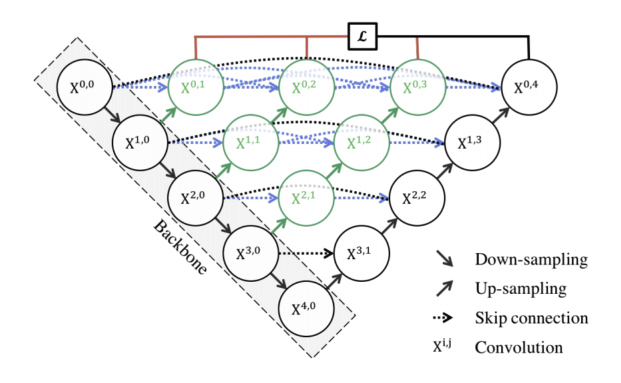

In [7]:
def conv_block(x, filters, name, kernel_size=3, activation='relu'):
    x = Conv2D(filters, kernel_size, padding='same', activation=activation, name=f"{name}_conv1")(x)
    x = Conv2D(filters, kernel_size, padding='same', activation=activation, name=f"{name}_conv2")(x)
    return x

In [7]:
def build_unet_plus_plus(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Level 1
    x00 = conv_block(inputs, 64, "x00")
    pool1 = MaxPooling2D(pool_size=(2, 2))(x00)

    # Level 2
    x10 = conv_block(pool1, 128, "x10")
    pool2 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv_block(Concatenate()([UpSampling2D()(x10), x00]), 64, "x01")

    # Level 3
    x20 = conv_block(pool2, 256, "x20")
    pool3 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv_block(Concatenate()([UpSampling2D()(x20), x10]), 128, "x11")
    x02 = conv_block(Concatenate()([UpSampling2D()(x11), x01, x00]), 64, "x02")

    # Level 4
    x30 = conv_block(pool3, 512, "x30")
    pool4 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv_block(Concatenate()([UpSampling2D()(x30), x20]), 256, "x21")
    x12 = conv_block(Concatenate()([UpSampling2D()(x21), x11, x10]), 128, "x12")
    x03 = conv_block(Concatenate()([UpSampling2D()(x12), x02, x01, x00]), 64, "x03")

    # Level 5 (bottleneck)
    x40 = conv_block(pool4, 1024, "x40")

    x31 = conv_block(Concatenate()([UpSampling2D()(x40), x30]), 512, "x31")
    x22 = conv_block(Concatenate()([UpSampling2D()(x31), x21, x20]), 256, "x22")
    x13 = conv_block(Concatenate()([UpSampling2D()(x22), x12, x11, x10]), 128, "x13")
    x04 = conv_block(Concatenate()([UpSampling2D()(x13), x03, x02, x01, x00]), 64, "x04")

    # Output layer
    outputs = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid', name="output")(x04)
    outputs = Reshape(input_shape[:2])(outputs)
    return Model(inputs=inputs, outputs=outputs)

In [10]:
x = np.random.randn(16, 224, 224, 3)
print("input", x.shape)
pp_model = build_unet_plus_plus()
outputs = pp_model(x)
print("output", outputs.shape)

input (16, 224, 224, 3)
output (16, 224, 224)


In [12]:
pp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
x00_conv1 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
x00_conv2 (Conv2D)              (None, 224, 224, 64) 36928       x00_conv1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           x00_conv2[0][0]                  
____________________________________________________________________________________________

In [73]:
model_path = "./model/seg_model_unet++_e300.keras"

pp_model = build_unet_plus_plus()
pp_model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=[class_1_accuracy])

csv_logger = tf.keras.callbacks.CSVLogger("./history/unet++_e300.log")
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    save_freq=11*100
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
)

pp_history = pp_model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=1000,
    callbacks=[csv_logger, ckpt, early_stop]
)

Level 1
Level 2
Level 3
Level 4
Level 5
Level out
Epoch 1/1000


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:622 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/utils.py:72 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['x00_conv1/kernel:0', 'x00_conv1/bias:0', 'x00_conv2/kernel:0', 'x00_conv2/bias:0', 'x10_conv1/kernel:0', 'x10_conv1/bias:0', 'x10_conv2/kernel:0', 'x10_conv2/bias:0', 'x20_conv1/kernel:0', 'x20_conv1/bias:0', 'x20_conv2/kernel:0', 'x20_conv2/bias:0', 'x30_conv1/kernel:0', 'x30_conv1/bias:0', 'x30_conv2/kernel:0', 'x30_conv2/bias:0', 'x40_conv1/kernel:0', 'x40_conv1/bias:0', 'x40_conv2/kernel:0', 'x40_conv2/bias:0', 'x31_conv1/kernel:0', 'x31_conv1/bias:0', 'x31_conv2/kernel:0', 'x31_conv2/bias:0', 'x21_conv1/kernel:0', 'x21_conv1/bias:0', 'x21_conv2/kernel:0', 'x21_conv2/bias:0', 'x11_conv1/kernel:0', 'x11_conv1/bias:0', 'x11_conv2/kernel:0', 'x11_conv2/bias:0', 'x01_conv1/kernel:0', 'x01_conv1/bias:0', 'x22_conv1/kernel:0', 'x22_conv1/bias:0', 'x01_conv2/kernel:0', 'x01_conv2/bias:0', 'x22_conv2/kernel:0', 'x22_conv2/bias:0', 'x12_conv1/kernel:0', 'x12_conv1/bias:0', 'x12_conv2/kernel:0', 'x12_conv2/bias:0', 'x02_conv1/kernel:0', 'x02_conv1/bias:0', 'x02_conv2/kernel:0', 'x02_conv2/bias:0', 'x13_conv1/kernel:0', 'x13_conv1/bias:0', 'x13_conv2/kernel:0', 'x13_conv2/bias:0', 'x03_conv1/kernel:0', 'x03_conv1/bias:0', 'x03_conv2/kernel:0', 'x03_conv2/bias:0', 'x04_conv1/kernel:0', 'x04_conv1/bias:0', 'x04_conv2/kernel:0', 'x04_conv2/bias:0', 'output/kernel:0', 'output/bias:0'].


* No gradients provided 문제로 train_step 구현

In [14]:
pp_model = build_unet_plus_plus()

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define the metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')


# Custom training step function
# @tf.function
def train_step(images, labels, training=True):
    with tf.GradientTape() as tape:
        predictions = pp_model(images, training=training)
        loss = loss_fn(labels, predictions)
    if training:
        gradients = tape.gradient(loss, pp_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)
    else:
        print("val")
        val_loss(loss)
        val_accuracy(labels, predictions)

# Training loop
def train(dataset, val_dataset, epochs):
    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        for images, labels in dataset:
            train_step(images, labels)

        for images, labels in val_dataset:
            train_step(images, labels, training=False)

        template = 'Epoch {}, loss: {}, val_loss: {}, val_accuracy: {}'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              val_loss.result(),
                              val_accuracy.result()))

train(train_generator, test_generator, 10)

ResourceExhaustedError: OOM when allocating tensor with shape[16,112,112,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

* OOM으로 학습 시키지 못함
* 모델을 수정해서 다시 학습

In [9]:
def build_unet_plus_plus_light(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Level 1
    x00 = conv_block(inputs, 64, "x00")
    pool1 = MaxPooling2D(pool_size=(2, 2))(x00)

    # Level 2
    x10 = conv_block(pool1, 128, "x10")
    pool2 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv_block(Concatenate()([UpSampling2D()(x10), x00]), 64, "x01")

    # Level 3
    x20 = conv_block(pool2, 256, "x20")
    pool3 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv_block(Concatenate()([UpSampling2D()(x20), x10]), 128, "x11")
    x02 = conv_block(Concatenate()([UpSampling2D()(x11), x01, x00]), 64, "x02")

    # Level 4
    x30 = conv_block(pool3, 512, "x30")
#     pool4 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv_block(Concatenate()([UpSampling2D()(x30), x20]), 256, "x21")
    x12 = conv_block(Concatenate()([UpSampling2D()(x21), x11, x10]), 128, "x12")
    x03 = conv_block(Concatenate()([UpSampling2D()(x12), x02, x01, x00]), 64, "x03")

#     # Level 5 (bottleneck)
#     x40 = conv_block(pool4, 1024, "x40")

#     x31 = conv_block(Concatenate()([UpSampling2D()(x40), x30]), 512, "x31")
#     x22 = conv_block(Concatenate()([UpSampling2D()(x31), x21, x20]), 256, "x22")
#     x13 = conv_block(Concatenate()([UpSampling2D()(x22), x12, x11, x10]), 128, "x13")
#     x04 = conv_block(Concatenate()([UpSampling2D()(x13), x03, x02, x01, x00]), 64, "x04")

    # Output layer
    outputs = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid', name="output")(x03)
    outputs = Reshape(input_shape[:2])(outputs)
    return Model(inputs=inputs, outputs=outputs)

In [9]:
x = np.random.randn(16, 224, 224, 3)
print("input", x.shape)
pp_model = build_unet_plus_plus_light()
outputs = pp_model(x)
print("output", outputs.shape)

input (16, 224, 224, 3)
output (16, 224, 224)


In [10]:
pp_model = build_unet_plus_plus_light()

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define the metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')


# Custom training step function
# @tf.function
def train_step(images, labels, training=True):
    with tf.GradientTape() as tape:
        predictions = pp_model(images, training=training)
        loss = loss_fn(labels, predictions)
    if training:
        gradients = tape.gradient(loss, pp_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pp_model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)
    else:
        val_loss(loss)
        val_accuracy(labels, predictions)

# Training loop
def train(dataset, val_dataset, epochs):
    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        for images, labels in dataset:
            train_step(images, labels)

        for images, labels in val_dataset:
            train_step(images, labels, training=False)

        template = 'Epoch {}, loss: {}, val_loss: {}, val_accuracy: {}'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              val_loss.result(),
                              val_accuracy.result()))

train(train_generator, test_generator, 10)

Epoch 1, loss: 0.3130413293838501, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 2, loss: 0.21988342702388763, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 3, loss: 0.22974343597888947, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 4, loss: 0.18770068883895874, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 5, loss: 0.22398637235164642, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 6, loss: 0.17692887783050537, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 7, loss: 0.2930748164653778, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 8, loss: 0.2519281208515167, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 9, loss: 0.20507501065731049, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578
Epoch 10, loss: 0.23445077240467072, val_loss: 0.28193968534469604, val_accuracy: 0.9817218780517578


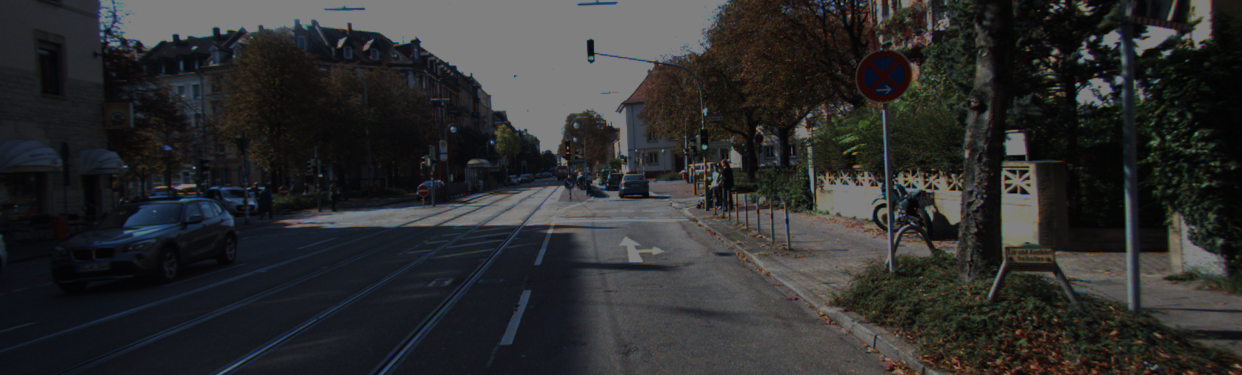

IoU : 0.000000


0.0

In [17]:
output, prediction, target = get_output(
    pp_model, 
    test_preproc,
    image_path=image_path,
    label_path=label_path,
    threshold=0.1
 )

calculate_iou_score(target, prediction)

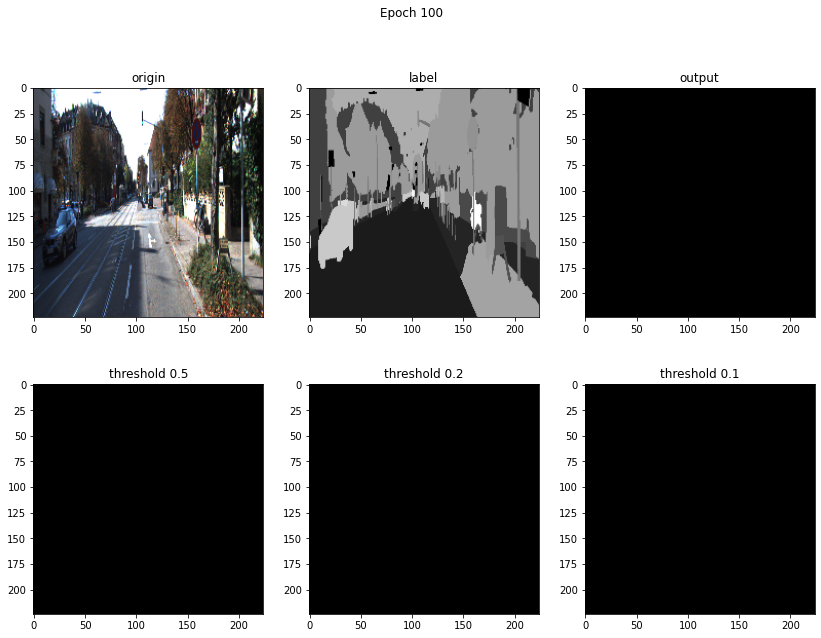

In [15]:
output = pp_model.predict(np.expand_dims(test_image/255,axis=0))[0]

plt.figure(figsize=(14, 10))
plt.suptitle(f"Epoch 100")
plt.subplot(231)
plt.title("origin")
plt.imshow(test_image)
plt.subplot(232)
plt.title("label")
plt.imshow(test_label, cmap="gray")
plt.subplot(233)
plt.title("output")
plt.imshow(output, cmap="gray")
plt.subplot(234)
plt.title("threshold 0.5")
plt.imshow(tf.where(output >= 0.5, 1, 0), cmap="gray")
plt.subplot(235)
plt.title("threshold 0.2")
plt.imshow(tf.where(output >= 0.2, 1, 0), cmap="gray")
plt.subplot(236)
plt.title("threshold 0.1")
plt.imshow(tf.where(output >= 0.1, 1, 0), cmap="gray")
plt.show()

## 회고
* 배운 점
    - Semantic Segmentation 에 대해 학습했습니다. U-Net, U-Net++ 등 여러 네트워크에 대한 구조와 장단점 대해 배울 수 있었습니다.
* 아쉬운 점
    - 논문의 세부적인 내용, 관련된 내용들이 많아 다 보지 못해서 아쉬웠습니다. 추후에 리뷰하고 정리해야합니다.
* 느낀 점
    - 여러 아이디어와 방법들을 실험해보고 의미있는 결과를 얻어내는 것이 중요하다고 느꼈습니다.
* 어려웠던 점
    - 데이터 마다 구조가 상이해 구성 방법이 복잡했습니다.